<a href="https://colab.research.google.com/github/brenoskuk/inpaiting/blob/main/Inpainting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors: Breno BALDAS SKUK and Rodrigo César LUIZ BROCHADO 

# Imports

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

from timeit import default_timer as timer

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.preprocessing import normalize


# 1. Inpaiting class

The inpaiting class contain all methods needed to apply inpaiting to an image, given a mask of the same size. This makes it easy to manipulate the images and see what is happening.

In [ ]:
# UNCOMENT IF NOT IN GOOGLE COLLAB
from google.colab.patches import cv2_imshow

#Defining Inpaint Class
class Criminisi_Inpaint:
    
    def __init__(self, source_img, target_mask, save_name = 'result_Criminisi.png', patch_size = 9, erosion_size = 3 , dilation_size = 5, print_mask_color = (127,127,127), cvt_gray = False, cvt_bgr = False):
        self.img = source_img
        self.save_name = save_name

        if cvt_gray and len(self.img.shape) == 3:
            self.img = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)

        if cvt_bgr and len(self.img.shape) < 3:
            self.img = cv2.cvtColor(self.img,cv2.COLOR_GRAY2RGB)

        if len(self.img.shape) < 3:
            self.print_mask_color = np.mean(print_mask_color)
        else:
            self.print_mask_color = print_mask_color

        self.height, self.width = self.img.shape[:2]
        self.target_mask = target_mask

        assert self.img.shape[:2] == self.target_mask.shape

        #Half patch size is used for finding the patch borders given it's center coordinates
        self.patch_size = patch_size
        self.half_patch_size = np.floor(self.patch_size/2).astype(np.int)

        #Defining erosion matrix size. Default is 3 for 1 pixel width erosion
        self.erosion_size = erosion_size

        #Defining dilation matrix size. Default is 5 for 2 pixel width dilation
        self.dilation_size = dilation_size
        
        #Create working image
        self.prepare()

    #Returns working image
    def prepare(self):
        # Defines initial confidence matrix as the inversion of the mask
        self.confidence_values = 1.0 - self.target_mask/255.0

        # working image = image - target mask
        working_img = np.zeros(self.img.shape)
        working_img[self.target_mask == 0] = self.img[self.target_mask == 0]
        working_img[self.target_mask != 0] = -1
        self.working_img = working_img

        self.erosion_kernel = np.ones((self.erosion_size, self.erosion_size),np.uint8)
        self.dilation_kernel_out = np.ones((self.dilation_size, self.dilation_size),np.uint8)
        self.dilation_kernel_in = np.ones((self.dilation_size-2, self.dilation_size-2),np.uint8)
    
# Creates dilation and erosion matrixes

    # working contour for mask is given by original image - eroded image
    def apply_erosion(self):
        erosion_mask = cv2.erode(self.target_mask,self.erosion_kernel,iterations = 1)
        self.erosion_diff = cv2.bitwise_xor(self.target_mask, erosion_mask)

    # working contour for gradient estimation is given by dilated image - image
    def apply_dilation(self):
        self.dilation_mask_out = cv2.dilate(self.target_mask, self.dilation_kernel_out,iterations = 1)
        self.dilation_mask_in = cv2.dilate(self.target_mask, self.dilation_kernel_in,iterations = 1)
        self.dilation_diff = cv2.bitwise_xor(self.dilation_mask_out, self.dilation_mask_in)

    def find_nearest_dilation(self, contour_inds, dilation_inds):
        nearest_ind = ([], [])
        append_0 = nearest_ind[0].append
        append_1 = nearest_ind[1].append
        for k in range(len(contour_inds[0])):
            distances = np.sqrt((contour_inds[0][k] - dilation_inds[0])**2 + (contour_inds[1][k] - dilation_inds[1])**2)
            append_0(dilation_inds[0][np.argmin(distances)])
            append_1(dilation_inds[1][np.argmin(distances)])
        self.nearest_index = nearest_ind

    def get_contours(self):
        # extracts index of contour masks
        self.contour_index = np.nonzero(self.erosion_diff)
        self.dilation_index = np.nonzero(self.dilation_diff)
        self.find_nearest_dilation(self.contour_index, self.dilation_index)

    # Given a contour returns boundaries of patches given their center (for every pixel in the image)
    def extract_patches_from_contour(self):    
        # 'initial' boundaries are limited by zero on both dimensions
        index_initial = np.maximum(np.array(self.contour_index)-self.half_patch_size,0)
        # 'final' boundaries are limited respectively by image height and widht
        index_end_height = np.minimum(self.contour_index[0]+self.half_patch_size+1, self.height)
        index_end_width = np.minimum(self.contour_index[1]+self.half_patch_size+1, self.width)
        # the 4 resulting values determine a patch given it's center
        patches_index_end = np.stack([index_end_height, index_end_width])
        bound = np.concatenate([index_initial, patches_index_end])
        self.patches_boundaries = bound
        self.patches_shape = np.array((bound[2]-bound[0],bound[3]-bound[1])).transpose()
    
    #Calculates the confidence matrix for each coordinate in a list of patches
    def calculate_confidence(self):
        bound = self.patches_boundaries
        conf = self.confidence_values
        #Creates vector of patches given list
        patches = [conf[bound[0,i]:bound[2,i],bound[1,i]:bound[3,i]] for i in range(bound.shape[1])]
        #Creates patches's confidence vector
        self.contour_confidence = np.array([np.sum(patch)/patch.size for patch in patches])

    def calculate_data(self):

        dy_mask, dx_mask = np.gradient(self.target_mask.astype(float))
        mask_grad = np.dstack([dx_mask, dy_mask])
        contour_norm = normalize(mask_grad[self.contour_index], norm='l2')

        if len(self.working_img.shape) > 2:
            contour_data = np.zeros(self.contour_confidence.shape)
            for ch  in range(3):
                dy_img, dx_img = np.gradient( self.working_img[:,:,ch].astype(float))
        #         img_grad = np.dstack([dx_img, dy_img])
                img_iso = np.dstack([-dy_img, dx_img])
                contour_data = contour_data + np.einsum('...i,...i', contour_norm,img_iso[self.nearest_index])
            self.contour_data = contour_data/(3*255) + 0.01
        else:
            dy_img, dx_img = np.gradient( self.working_img.astype(float))
    #         img_grad = np.dstack([dx_img, dy_img])
            img_iso = np.dstack([-dy_img, dx_img])
            self.contour_data = np.einsum('...i,...i', contour_norm,img_iso[self.nearest_index])/255 + 0.01

    def find_best_source(self, current_patch, pat_shape):
        compare_patch = current_patch[current_patch>=0]
        compare_pats_source = self.patches_dict[pat_shape][:,current_patch>=0]
        result_mse = np.mean(np.square(compare_pats_source - compare_patch), axis=1)
#         return self.patches_dict[pat_shape][np.argmin(result_mse),:,:]
        candidates = self.patches_dict[pat_shape][result_mse == result_mse.min(),:,:]
        if candidates.shape[0] > 1:
            compare_vars = np.var(candidates[:,current_patch>=0], axis=1)
            missing_vars = np.var(candidates[:,current_patch<0], axis=1)
            diff_var = abs(compare_vars - missing_vars)
            return candidates[np.argmin(diff_var)]
        else:
            return candidates[0]

    def show_working_image(self, use_opencv=False):
        print_img = self.working_img.copy()
        if len(print_img.shape) > 2:
            print_img[print_img[:,:,0] < 0, 0] = self.print_mask_color[0]
            print_img[print_img[:,:,1] < 0, 1] = self.print_mask_color[1]
            print_img[print_img[:,:,2] < 0, 2] = self.print_mask_color[2]
        else:
            print_img[print_img < 0] = self.print_mask_color

        if use_opencv:
            #Show the working img with OpenCV
            #cv2.imshow('Working Image', print_img.astype(np.uint8))
            #cv2.waitKey(100)
            # UNCOMMENT IF NOT IN GOOGLE COLLAB
            
            cv2_imshow(print_img.astype(np.uint8))
            cv2.waitKey(100)
        else:
            if len(self.print_img.shape) > 2:
                #Show the working img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.imshow(cv2.cvtColor(print_img.astype(np.uint8)), cv2.COLOR_BGR2RGB)
                plt.show()
            else:
                #Show the working img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.imshow(print_img.astype(np.uint8), cmap='gray')
                plt.show()

    def show_image(self, use_opencv=False):
        if use_opencv:
            #Show the source img with OpenCV
            cv2_imshow(self.img.astype(np.uint8))
            cv2.waitKey(100)
        else:
            if len(self.img.shape) > 2:
                #Show the source img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.imshow(cv2.cvtColor(self.img.astype(np.uint8), cv2.COLOR_BGR2RGB))
                plt.show()
            else:
                #Show the source img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.imshow(self.img.astype(np.uint8), cmap='gray')
                plt.show()

    def show_target_mask(self, use_opencv=False):
        if use_opencv:
            #Show the working img with OpenCV
            cv2_imshow(self.target_mask.astype(np.uint8))
            cv2.waitKey(100)
        else:
            #Show the working img with matplotlib
            plt.rcParams['figure.figsize'] = [15, 15]
            plt.imshow(self.target_mask.astype(np.uint8), cmap='gray')
            plt.show()

    def show_working_image_and_mask(self, use_opencv=False):
        print_img = self.working_img.copy()
        if len(print_img.shape) > 2:
            print_img[print_img[:,:,0] < 0, 0] = self.print_mask_color[0]
            print_img[print_img[:,:,1] < 0, 1] = self.print_mask_color[1]
            print_img[print_img[:,:,2] < 0, 2] = self.print_mask_color[2]
        else:
            print_img[print_img < 0] = self.print_mask_color

        if len(print_img.shape) > 2:
            if use_opencv:
                #Show the working img with OpenCV
                cv2_imshow(cv2.hconcat([print_img.astype(np.uint8), cv2.cvtColor(self.target_mask.astype(np.uint8),cv2.COLOR_GRAY2RGB).astype(np.uint8)]))
                cv2.waitKey(100)
            else:
                #Show the working img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.subplot(121),plt.imshow(cv2.cvtColor(print_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
                plt.subplot(122),plt.imshow(self.target_mask.astype(np.uint8), cmap='gray')
                plt.show()
        else:
            if use_opencv:
                #Show the working img with OpenCV
                cv2_imshow('Working Image and Mask', cv2.hconcat([print_img.astype(np.uint8), self.target_mask.astype(np.uint8)]))
                cv2.waitKey(100)
            else:
                #Show the working img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.subplot(121),plt.imshow(print_img.astype(np.uint8), cmap='gray')
                plt.subplot(122),plt.imshow(self.target_mask.astype(np.uint8), cmap='gray')
                plt.show()

    def show_working_image_and_image(self, use_opencv=False):
        print_img = self.working_img.copy()
        if len(print_img.shape) > 2:
            print_img[print_img[:,:,0] < 0, 0] = self.print_mask_color[0]
            print_img[print_img[:,:,1] < 0, 1] = self.print_mask_color[1]
            print_img[print_img[:,:,2] < 0, 2] = self.print_mask_color[2]
        else:
            print_img[print_img < 0] = self.print_mask_color

        if len(print_img.shape) > 2:
            if use_opencv:
                #Show the working img with OpenCV
                cv2_imshow(cv2.hconcat([print_img.astype(np.uint8), self.img.astype(np.uint8)]))
                cv2.waitKey(100)
            else:
                #Show the working img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.subplot(121),plt.imshow(cv2.cvtColor(print_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
                plt.subplot(122),plt.imshow(cv2.cvtColor(self.img.astype(np.uint8), cv2.COLOR_BGR2RGB))
                plt.show()
        else:
            if use_opencv:
                #Show the working img with OpenCV
                cv2_imshow(cv2.hconcat([print_img.astype(np.uint8), self.img.astype(np.uint8)]))
                cv2.waitKey(100)
            else:
                #Show the working img with matplotlib
                plt.rcParams['figure.figsize'] = [15, 15]
                plt.subplot(121),plt.imshow(print_img.astype(np.uint8), cmap='gray')
                plt.subplot(122),plt.imshow(self.img.astype(np.uint8), cmap='gray')
                plt.show()

    def save_result(self):
        save_img = self.working_img.copy()
        if len(save_img.shape) > 2:
            save_img[save_img[:,:,0] < 0, 0] = self.print_mask_color[0]
            save_img[save_img[:,:,1] < 0, 1] = self.print_mask_color[1]
            save_img[save_img[:,:,2] < 0, 2] = self.print_mask_color[2]
        else:
            save_img[save_img < 0] = self.print_mask_color

        cv2.imwrite(self.save_name, save_img)
        print('Result saved to', self.save_name)

    def inpaint (self, SHOW_STEPS=False, MAX_ITERATIONS=10000):

        self.patches_dict = {}
        #main loop will stop if target_mask becomes all zeroes
        all_zeros = not np.any(self.target_mask)
        cnt_iterations = 0
        while (not all_zeros and cnt_iterations < MAX_ITERATIONS):
            if SHOW_STEPS:
                print(cnt_iterations, end=" || ")

            #get contour of the mask every time a loop begins
            self.apply_erosion()
            self.apply_dilation()

            #get patches indexes from contour
            self.get_contours()
            self.extract_patches_from_contour()
            bounds = self.patches_boundaries

            self.calculate_confidence()
            self.calculate_data()

            #value of priorities is given by comparing with contour_data
            priority_value = self.contour_confidence*self.contour_data
            i = np.argmin(-priority_value)

            pat_shape = tuple(self.patches_shape[i].tolist())
            if pat_shape not in self.patches_dict.keys():
                pats = extract_patches_2d(self.working_img, pat_shape)
                pats_source = pats[np.all(pats>=0, axis=tuple(range(1, len(pats.shape))))]
                pats_source_unique = np.unique(pats_source, axis=0)
                self.patches_dict[pat_shape] = pats_source_unique
                if SHOW_STEPS:
                    print(cnt_iterations, pat_shape, ' - Adicionando ', pats.shape, pats_source.shape, pats_source_unique.shape)

            if self.target_mask[self.contour_index[0][i], self.contour_index[1][i]] == 0:
                continue

            if SHOW_STEPS:
#                 self.show_working_image()
                self.show_working_image_and_mask(True)

            current_patch = self.working_img[bounds[0,i]:bounds[2,i],bounds[1,i]:bounds[3,i]]

            current_patch_confidence = self.confidence_values[bounds[0,i]:bounds[2,i],bounds[1,i]:bounds[3,i]]
            if len(current_patch.shape) > 2:
                current_patch_confidence[current_patch[:,:,0]<0] = self.contour_confidence[i]
            else:
                current_patch_confidence[current_patch<0] = self.contour_confidence[i]
            self.confidence_values[bounds[0,i]:bounds[2,i],bounds[1,i]:bounds[3,i]] = current_patch_confidence

            #substitutes current patch
            best_source_patch = self.find_best_source(current_patch, pat_shape)
            current_patch[current_patch<0] = best_source_patch[current_patch<0]
            self.working_img[bounds[0,i]:bounds[2,i],bounds[1,i]:bounds[3,i]] = current_patch

            #substitutes mask region with zeroes
            self.target_mask[bounds[0,i]:bounds[2,i],bounds[1,i]:bounds[3,i]] = 0

            #check if mask contains only zeroes
            all_zeros = not np.any(self.target_mask)
            cnt_iterations = cnt_iterations+1
        if SHOW_STEPS:
            if (all_zeros):
                print("\nInpainting complete...\nNumber of Iterations: ",cnt_iterations+1)
            else:
                print("\nInpainting incomplete...\nMaximun number of iterations exceeded")
        cv2.destroyAllWindows()

# 2. Download additional files

You can upload your own masks and images.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1-Hf_PYyhhh2wHElpZyLOf5EN5dcVb_x6',
                                    dest_path='./data.zip',
                                    unzip=True)


# 3. Inpaiting

### 1. Choose mask and image address

In [ ]:
%matplotlib inline
# The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

# img_address = 'images/baseball.png'
# img_address = 'images/elephant.png'
# img_address = 'images/face.png'
# img_address = 'images/goalkeeper.png'
# img_address = 'images/nature.jpg'
# img_address = 'images/smile.png'
# img_address = 'images/synthese.jpg'
img_address = 'images/nature.jpg'

# mask_address = 'masks/maskChess.png'
# mask_address = 'masks/maskCirc.png'
# mask_address = 'masks/maskGoalkeeper.png'
# mask_address = 'masks/maskHard.png'
# mask_address = 'masks/maskR.png'
# mask_address = 'masks/maskSquare.png'
# mask_address = 'masks/synthese_mask5.jpg'
mask_address = 'masks/maskSquare.png'

source_img = cv2.imread(img_address)

### 2. Creating inpaint object

In [ ]:
mask = cv2.imread(mask_address, 0)
_, mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

save_name = os.path.join('results', os.path.splitext(os.path.basename(img_address))[0]+'_'+os.path.splitext(os.path.basename(mask_address))[0]+'.png')

# creates the inpaiting object, next we will apply the methods
A = Criminisi_Inpaint(source_img, mask, save_name = save_name, patch_size = 11, print_mask_color = (255,0,0))

### 3. Let's see the mask and the image

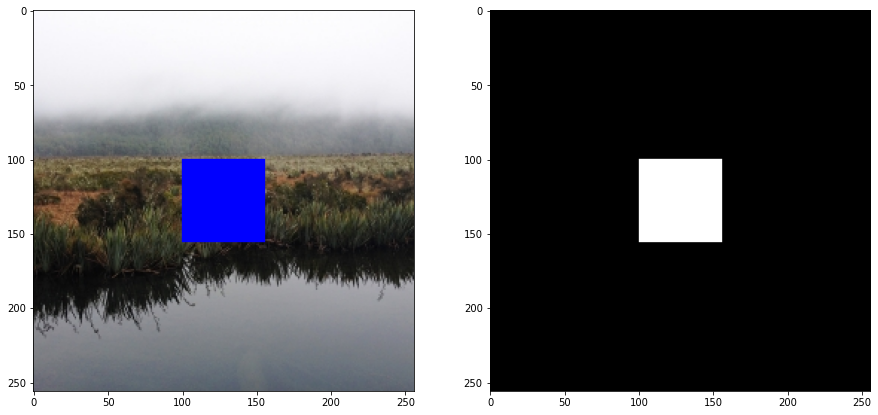

In [ ]:
A.show_working_image_and_mask()

### 4. Let's inpaint!

" SHOW_STEPS = True " will show the inpaiting process on the fly but takes a bit more time to inpaint.

0 || 0 (11, 11)  - Adicionando  (60516, 11, 11, 3) (56160, 11, 11, 3) (56160, 11, 11, 3)


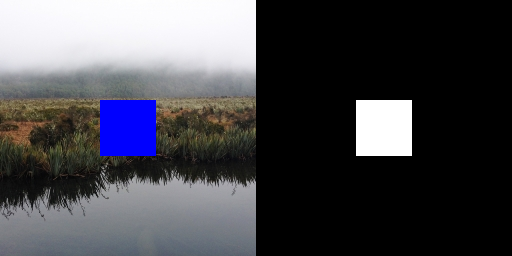

1 || 

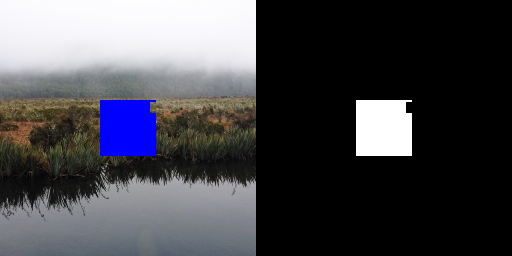

2 || 

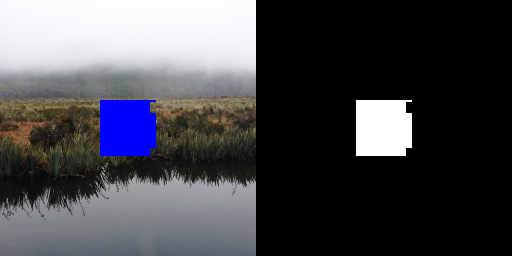

3 || 

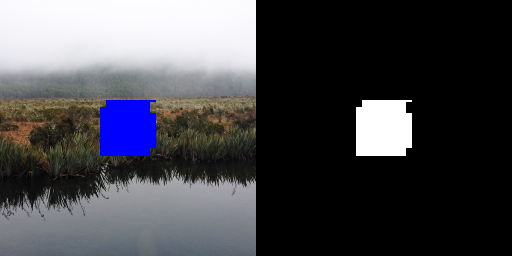

4 || 

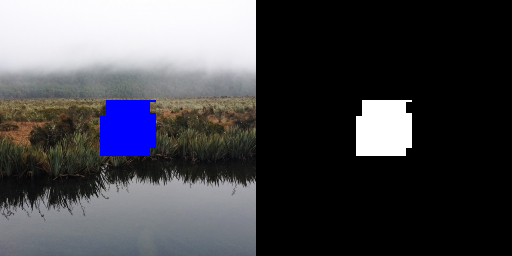

5 || 

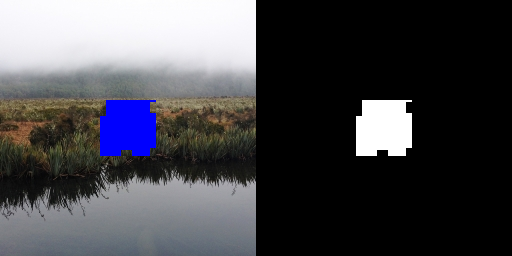

6 || 

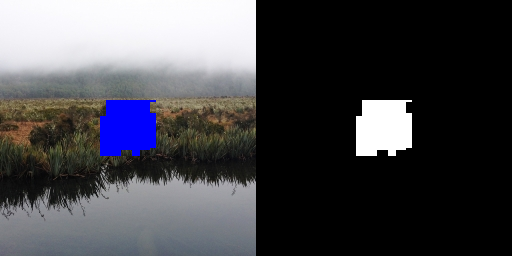

7 || 

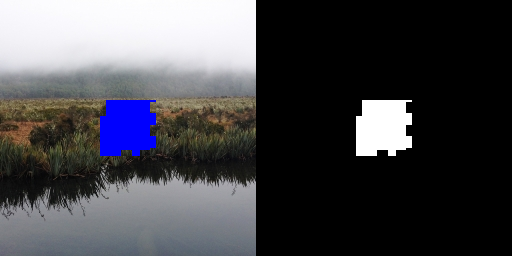

8 || 

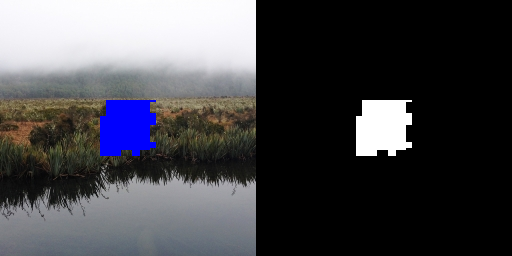

9 || 

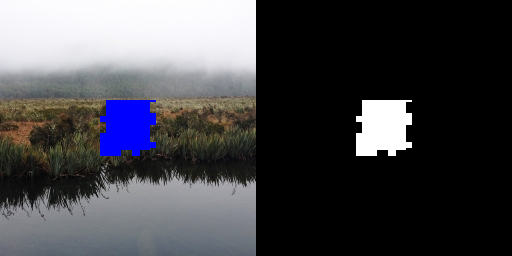

10 || 

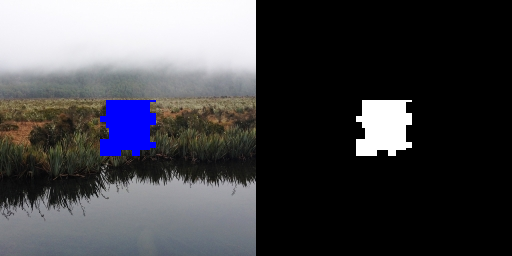

11 || 

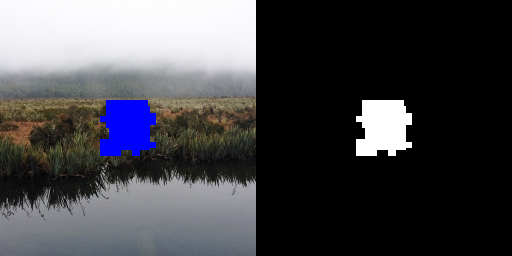

12 || 

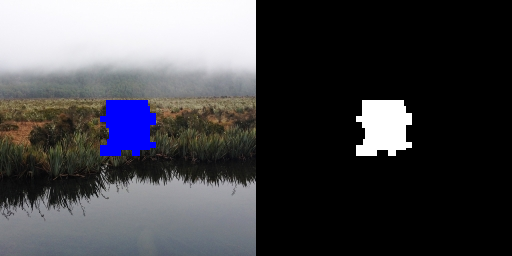

13 || 

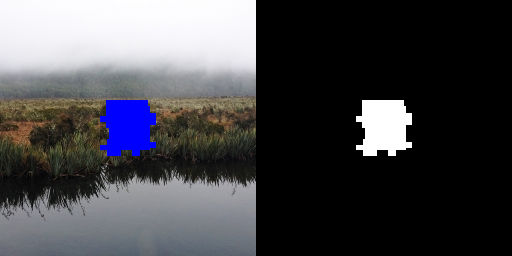

14 || 

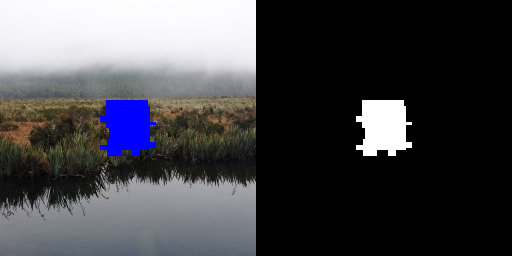

15 || 

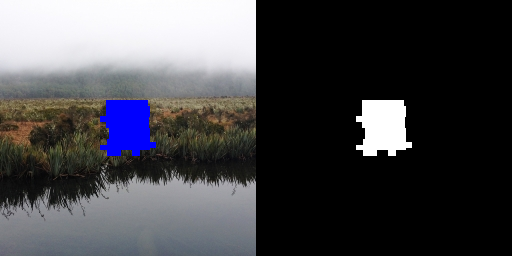

16 || 

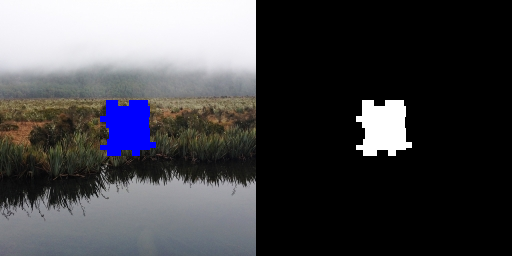

17 || 

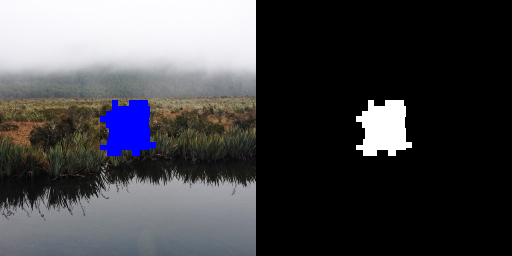

18 || 

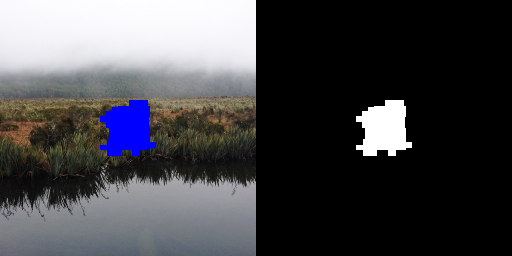

19 || 

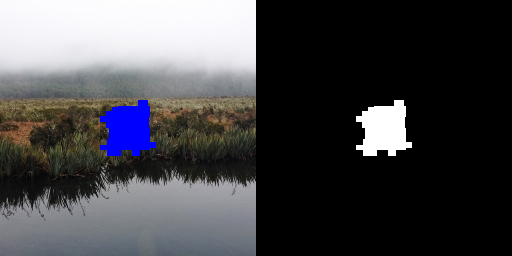

20 || 

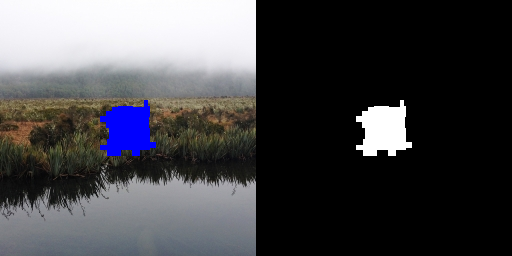

21 || 

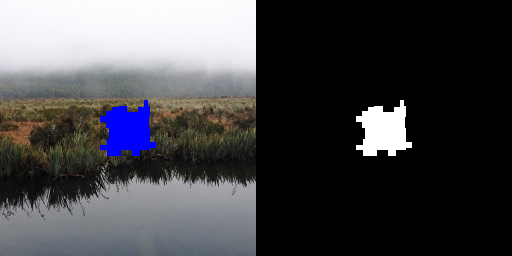

22 || 

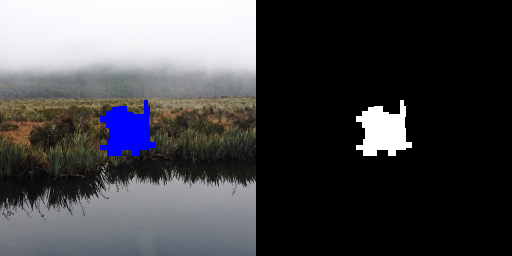

23 || 

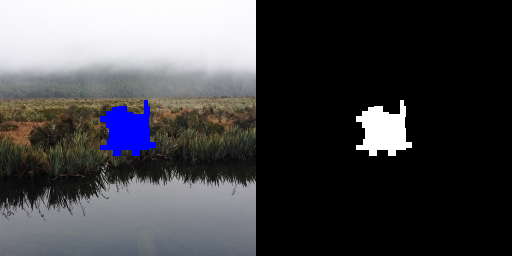

24 || 

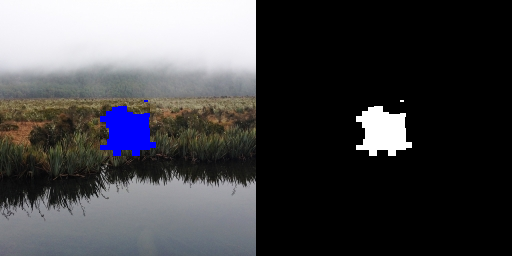

25 || 

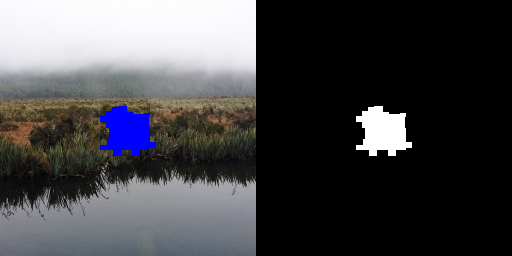

26 || 

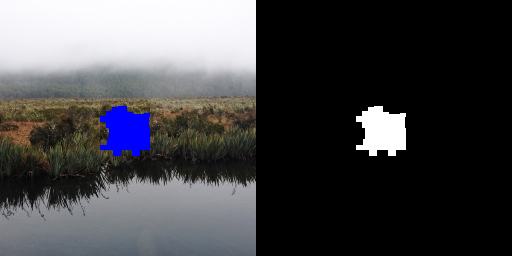

27 || 

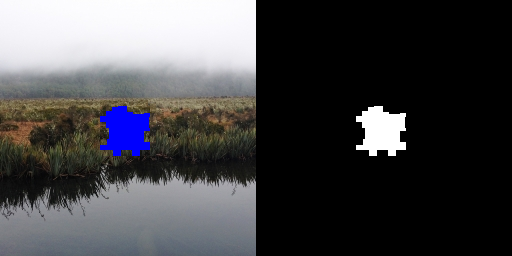

28 || 

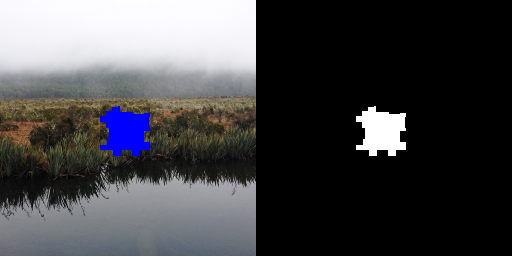

29 || 

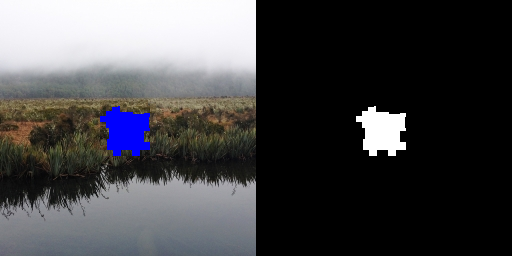

30 || 

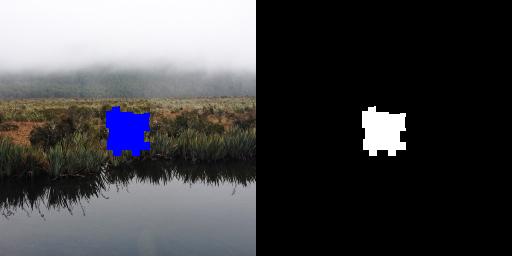

31 || 

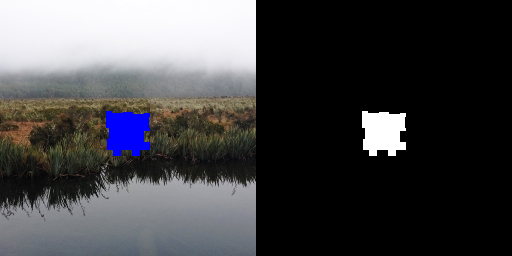

32 || 

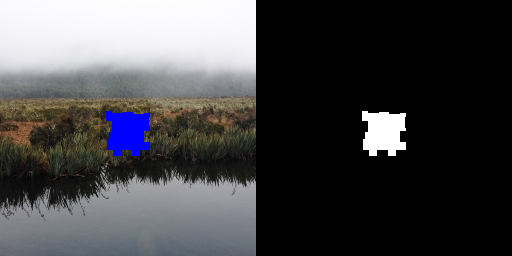

33 || 

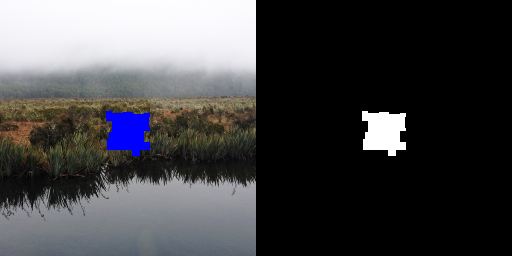

34 || 

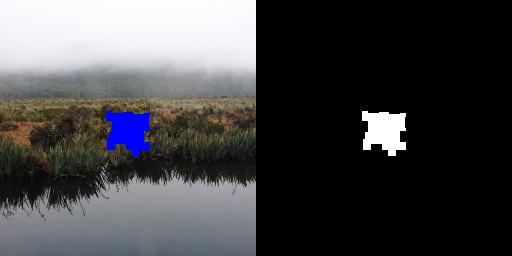

35 || 

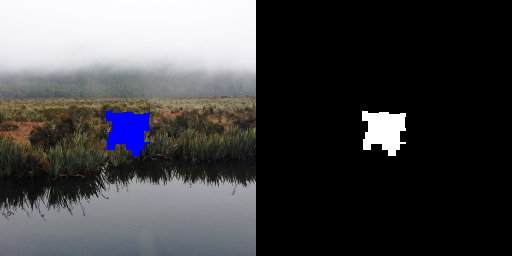

36 || 

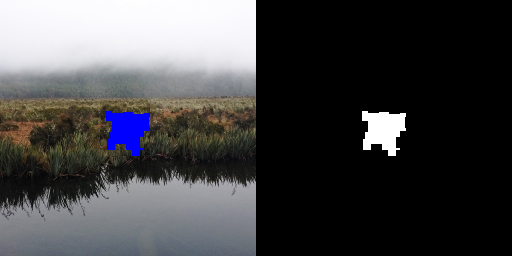

37 || 

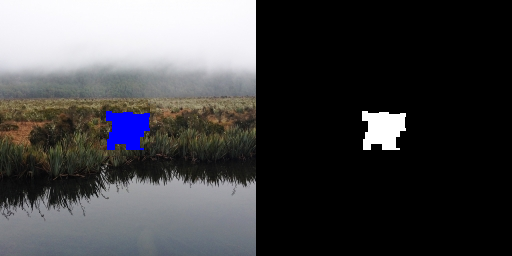

38 || 

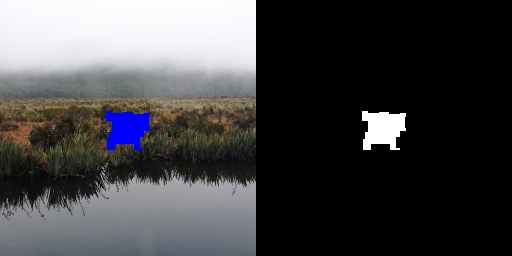

39 || 

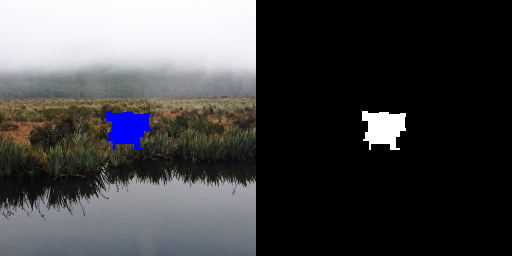

40 || 

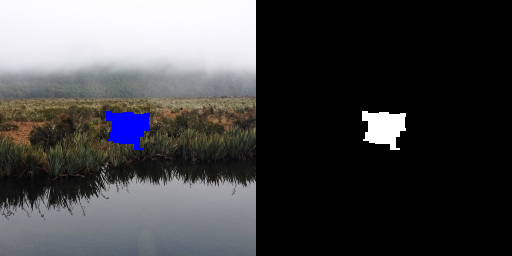

41 || 

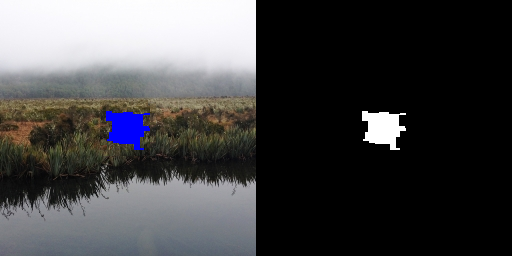

42 || 

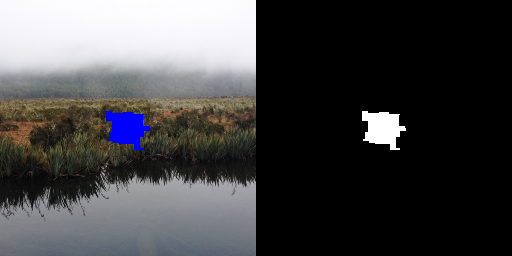

43 || 

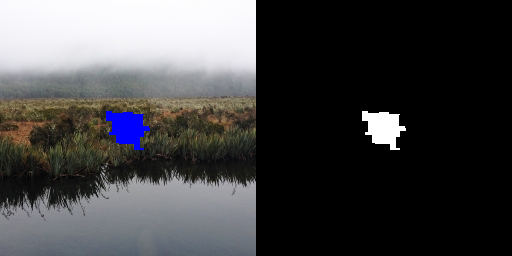

44 || 

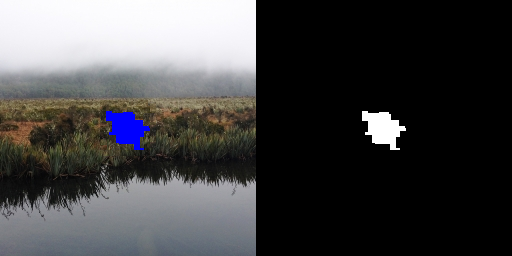

45 || 

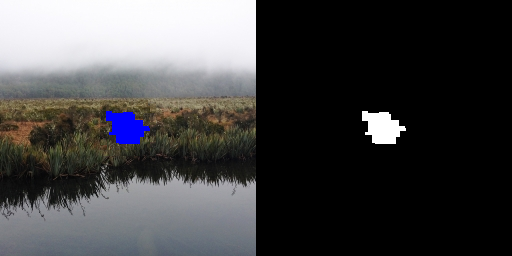

46 || 

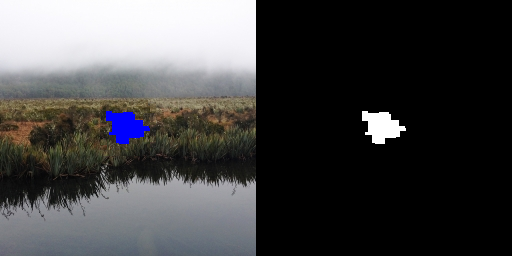

47 || 

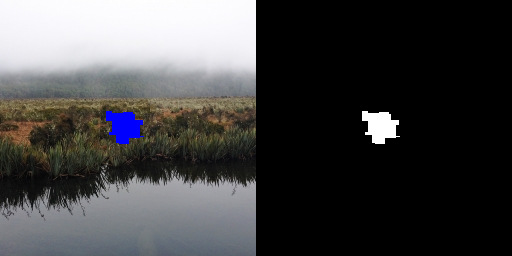

48 || 

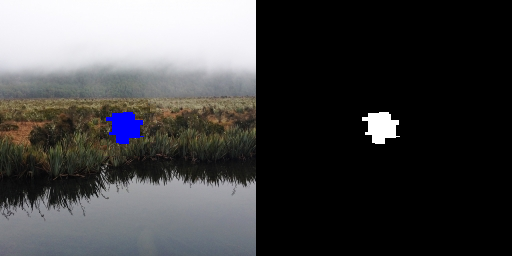

49 || 

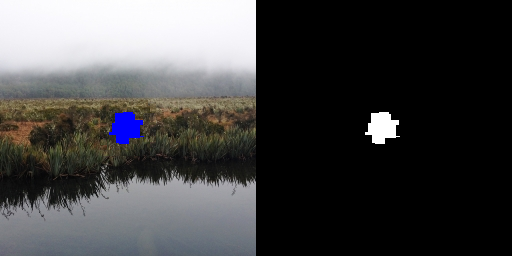

50 || 

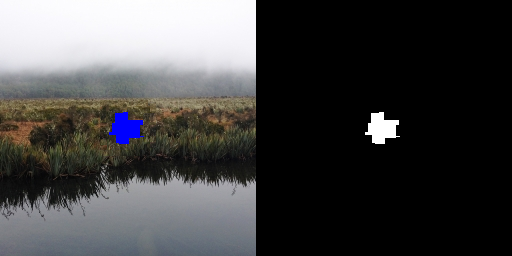

51 || 

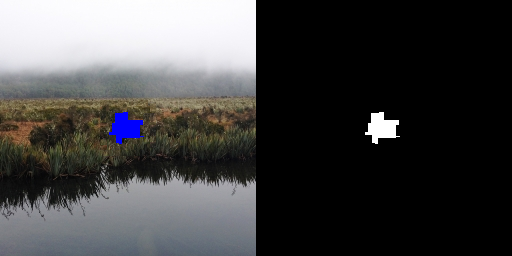

52 || 

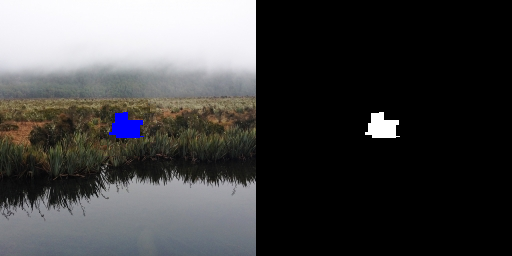

53 || 

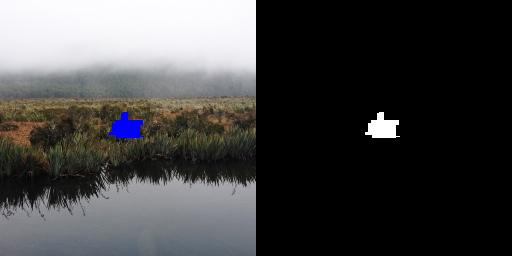

54 || 

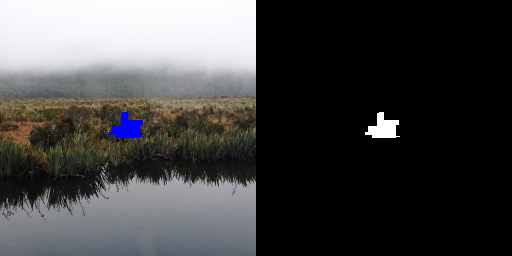

55 || 

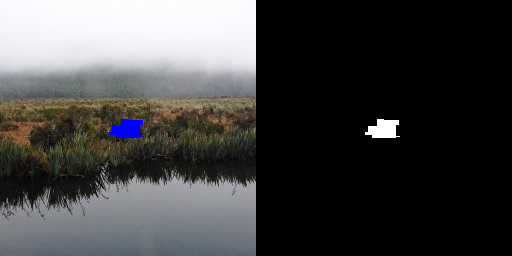

56 || 

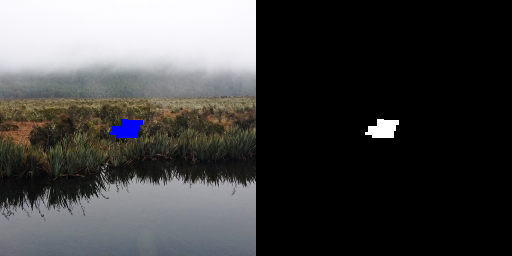

57 || 

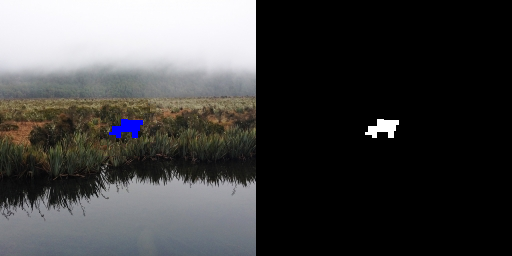

58 || 

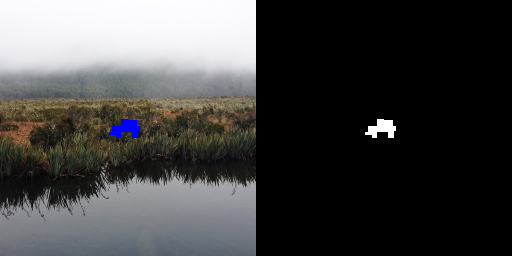

59 || 

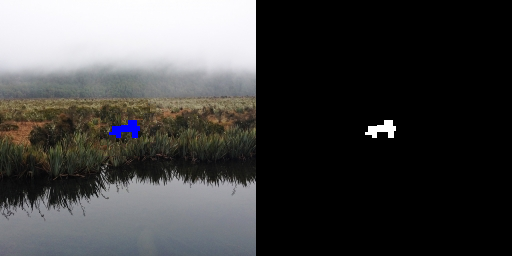

60 || 

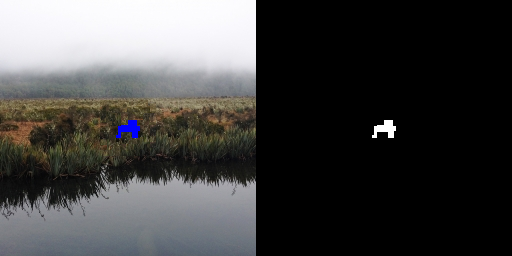

61 || 

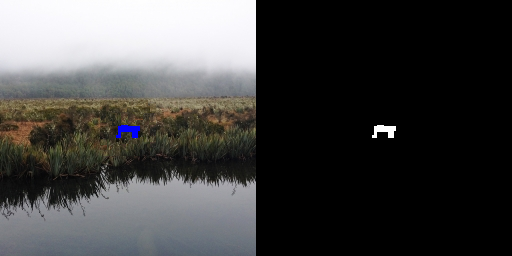

62 || 

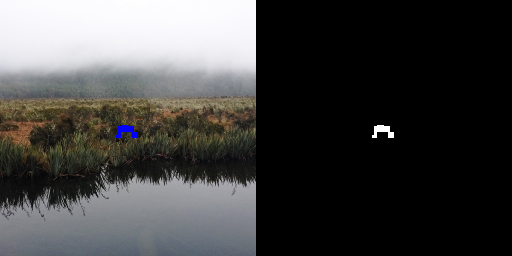

63 || 

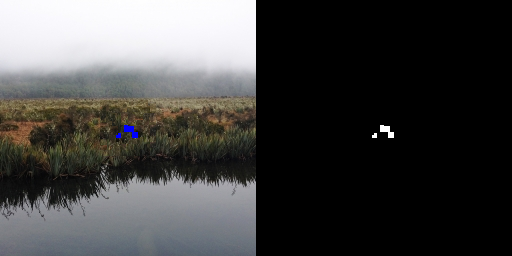

64 || 

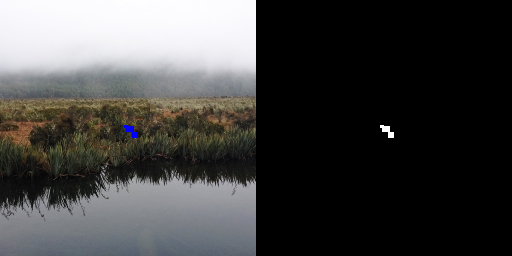

65 || 

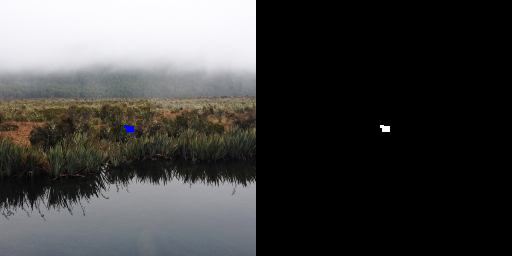

66 || 

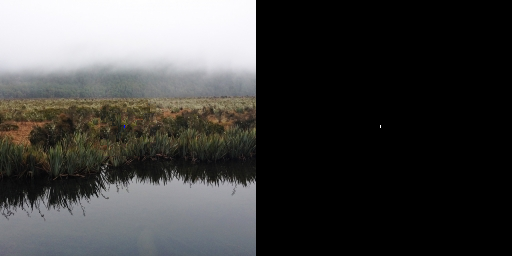


Inpainting complete...
Number of Iterations:  68


In [ ]:
A.inpaint(SHOW_STEPS=True)

### 5. Show the resulting image and original image side by side

Inpainted image is the left one.

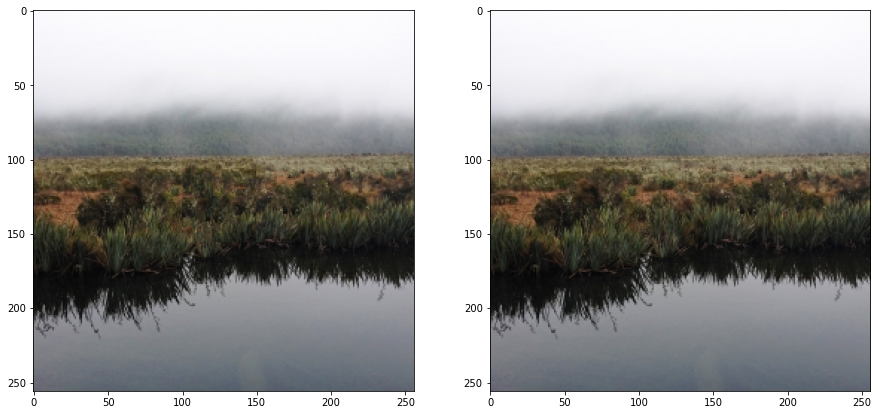

In [ ]:
A.show_working_image_and_image()